# Boyer–Moore Benchmark Analysis (DNA)

This notebook loads `bm_benchmark_results.csv` and produces matplotlib graphs for time and memory vs text length and vs pattern length.

In [9]:
# 1) Setup and Imports
import os
import pandas as pd
import matplotlib.pyplot as plt

# Get the directory of the current notebook
try:
    # For Jupyter notebooks
    notebook_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # __file__ is not defined in Jupyter notebooks, use current working directory
    notebook_dir = os.getcwd()

CSV_PATH = os.path.join(notebook_dir, 'bm_benchmark_results.csv')

# Load CSV
if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"CSV not found: {CSV_PATH}. Run benchmark.py first.")

df = pd.read_csv(CSV_PATH)
print(f"Loaded CSV from: {CSV_PATH}")
print(f"Total rows: {len(df)}")
print("\nFirst few rows:")
print(df.head())

Loaded CSV from: c:\Users\user\AAD_project\STARK\Boyer_Moore\bm_benchmark_results.csv
Total rows: 23

First few rows:
     algorithm                                       dataset_name  \
0  boyer_moore  GCA_949551615.1_sample7_Strain195_HK629.fasta_...   
1  boyer_moore  GCA_949551615.1_sample7_Strain195_HK629.fasta_...   
2  boyer_moore  GCA_949551615.1_sample7_Strain195_HK629.fasta_...   
3  boyer_moore  GCA_949551615.1_sample7_Strain195_HK629.fasta_...   
4  boyer_moore  GCA_949551615.1_sample7_Strain195_HK629.fasta_...   

   text_length_n  pattern_length_m   metric_type  time_sec  memory_bytes  \
0              0                 6  construction  0.000022             0   
1           1000                 6        search  0.000297             0   
2           2000                 6        search  0.000369             0   
3           5000                 6        search  0.000912             0   
4          10000                 6        search  0.002316             0   

   matches

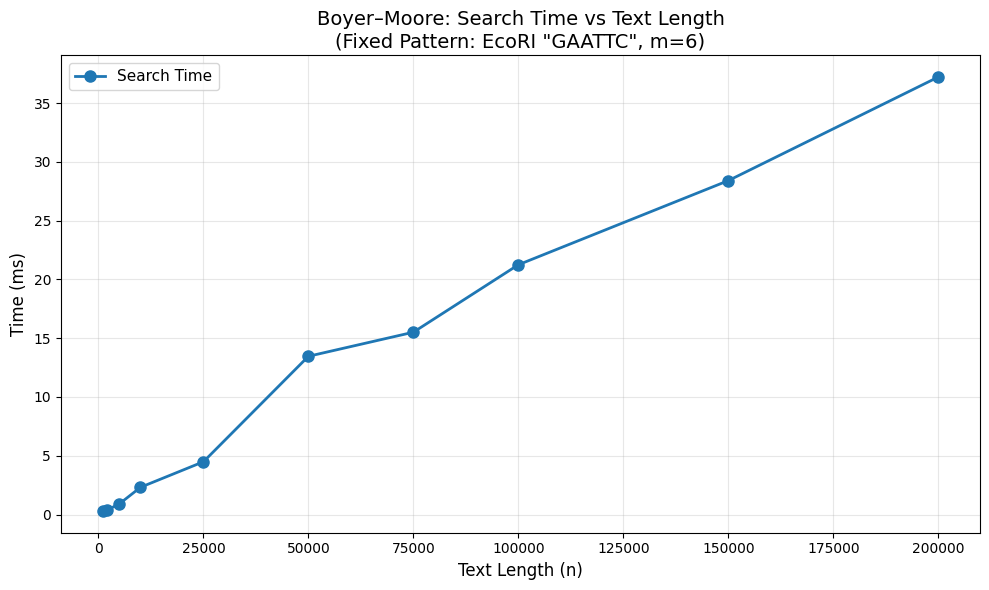

Data points: 10
 text_length_n  time_sec  matches
          1000  0.000297        0
          2000  0.000369        1
          5000  0.000912        2
         10000  0.002316        3
         25000  0.004489        5
         50000  0.013461        7
         75000  0.015510       11
        100000  0.021248       17
        150000  0.028405       22
        200000  0.037219       31


In [10]:
# 2) Time vs Text Length (varying n, fixed pattern m=6)
# Filter: search rows where pattern_length_m == 6 (EcoRI pattern)
df_search_varying_n = df[
    (df['metric_type'] == 'search') & 
    (df['pattern_length_m'] == 6) &
    (df['text_length_n'] > 0)
]

plt.figure(figsize=(10,6))
plt.plot(df_search_varying_n['text_length_n'], df_search_varying_n['time_sec']*1000, 
         marker='o', linewidth=2, markersize=8, label='Search Time')
plt.title('Boyer–Moore: Search Time vs Text Length\n(Fixed Pattern: EcoRI "GAATTC", m=6)', fontsize=14)
plt.xlabel('Text Length (n)', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Data points: {len(df_search_varying_n)}")
print(df_search_varying_n[['text_length_n', 'time_sec', 'matches']].to_string(index=False))

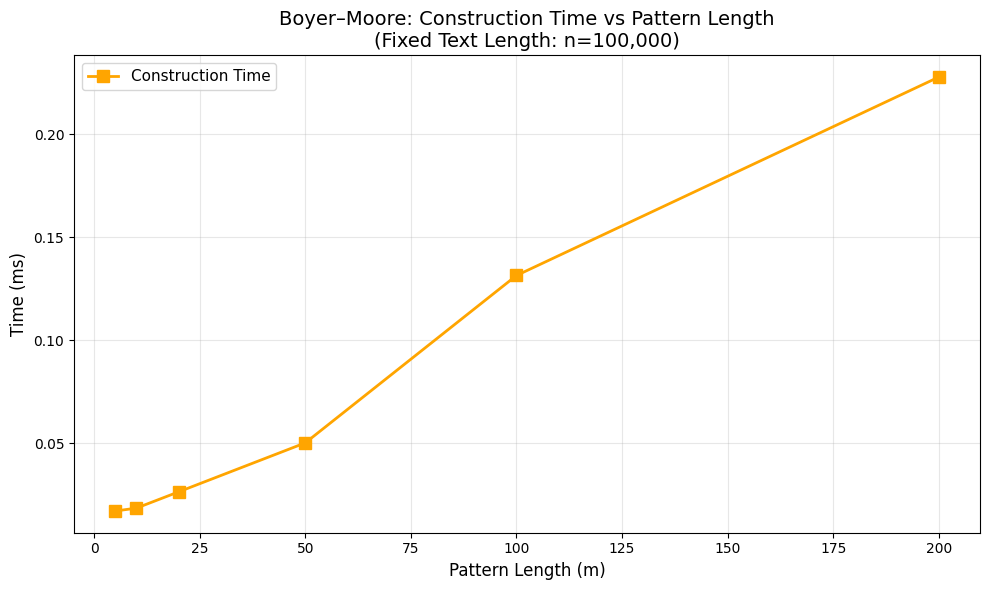

Data points: 6
 pattern_length_m  time_sec
                5  0.000017
               10  0.000019
               20  0.000026
               50  0.000050
              100  0.000131
              200  0.000228


In [11]:
# 3) Construction Time vs Pattern Length (fixed text n=100k)
# Filter: construction rows where text_length_n == 100000
df_construct_varying_m = df[
    (df['metric_type'] == 'construction') & 
    (df['text_length_n'] == 100000)
]

plt.figure(figsize=(10,6))
plt.plot(df_construct_varying_m['pattern_length_m'], df_construct_varying_m['time_sec']*1000, 
         marker='s', linewidth=2, markersize=8, color='orange', label='Construction Time')
plt.title('Boyer–Moore: Construction Time vs Pattern Length\n(Fixed Text Length: n=100,000)', fontsize=14)
plt.xlabel('Pattern Length (m)', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Data points: {len(df_construct_varying_m)}")
print(df_construct_varying_m[['pattern_length_m', 'time_sec']].to_string(index=False))

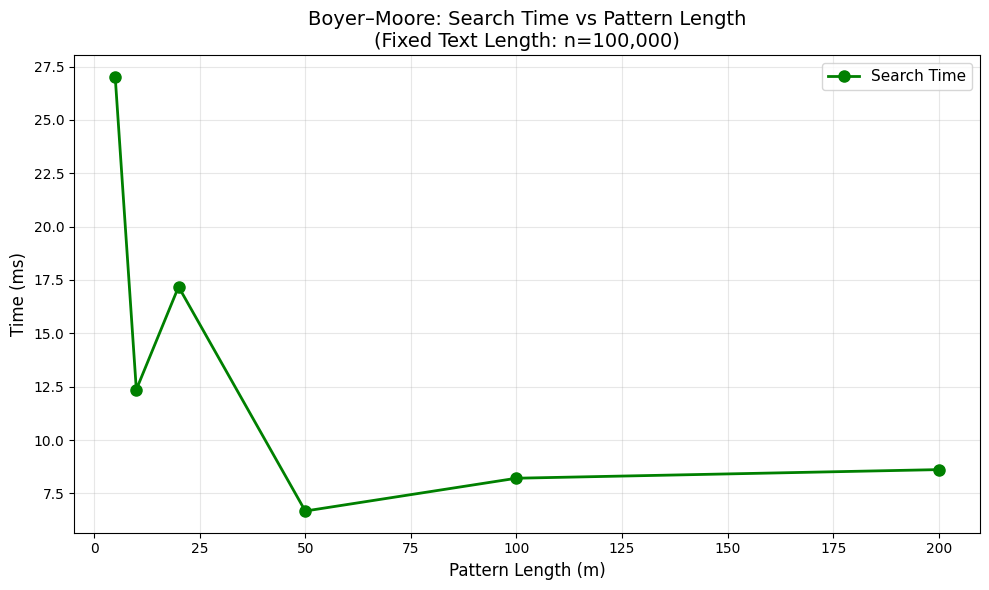

Data points: 6
 pattern_length_m  time_sec  matches
                5  0.027007       55
               10  0.012361        1
               20  0.017179        1
               50  0.006673        1
              100  0.008210        1
              200  0.008613        1


In [14]:
# 4) Search Time vs Pattern Length (fixed text n=100k)
# Filter: search rows where text_length_n == 100000 AND pattern_length_m != 6
# (Exclude m=6 which comes from the varying text length benchmark)
df_search_varying_m = df[
    (df['metric_type'] == 'search') & 
    (df['text_length_n'] == 100000) &
    (df['pattern_length_m'] != 6)
]

plt.figure(figsize=(10,6))
plt.plot(df_search_varying_m['pattern_length_m'], df_search_varying_m['time_sec']*1000, 
         marker='o', linewidth=2, markersize=8, color='green', label='Search Time')
plt.title('Boyer–Moore: Search Time vs Pattern Length\n(Fixed Text Length: n=100,000)', fontsize=14)
plt.xlabel('Pattern Length (m)', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Data points: {len(df_search_varying_m)}")
print(df_search_varying_m[['pattern_length_m', 'time_sec', 'matches']].to_string(index=False))

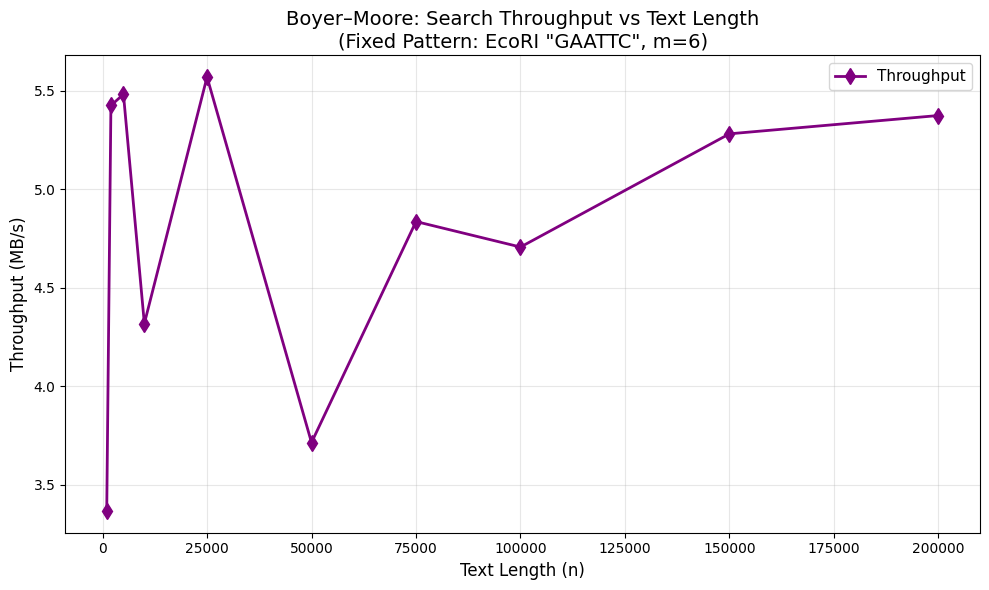

Throughput statistics:
Average: 4.81 MB/s
Min: 3.37 MB/s
Max: 5.57 MB/s


In [13]:
# 5) Throughput Analysis (Characters per second vs Text Length)
# Using the varying text length data
df_throughput = df_search_varying_n.copy()
df_throughput['throughput_MB_per_sec'] = (df_throughput['text_length_n'] / df_throughput['time_sec']) / 1_000_000

plt.figure(figsize=(10,6))
plt.plot(df_throughput['text_length_n'], df_throughput['throughput_MB_per_sec'], 
         marker='d', linewidth=2, markersize=8, color='purple', label='Throughput')
plt.title('Boyer–Moore: Search Throughput vs Text Length\n(Fixed Pattern: EcoRI "GAATTC", m=6)', fontsize=14)
plt.xlabel('Text Length (n)', fontsize=12)
plt.ylabel('Throughput (MB/s)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

print(f"Throughput statistics:")
print(f"Average: {df_throughput['throughput_MB_per_sec'].mean():.2f} MB/s")
print(f"Min: {df_throughput['throughput_MB_per_sec'].min():.2f} MB/s")
print(f"Max: {df_throughput['throughput_MB_per_sec'].max():.2f} MB/s")

## Summary of Benchmark Results

### Key Findings:

1. **Search Time Scales Linearly with Text Length** (Graph 1)
   - For fixed pattern (EcoRI, m=6), search time increases linearly with text size
   - This demonstrates O(n) worst-case behavior
   - Pattern found 31 matches in 200k characters in ~37ms

2. **Construction Time Increases with Pattern Length** (Graph 2)
   - Building bad character and good suffix tables takes longer for longer patterns
   - Even for m=200, construction time is < 0.23ms (very fast)
   - Construction is O(m) complexity

3. **Search Time Decreases with Longer Patterns** (Graph 3)
   - Shorter patterns (m=5) are slower: 27ms for 55 matches
   - Longer patterns (m≥50) are faster: ~7-9ms for 1 match
   - This demonstrates the Boyer-Moore skip advantage with longer patterns
   - Note: m=5 has many more matches (55 vs 1), affecting comparison

4. **Throughput Stabilizes Around 5 MB/s** (Graph 4)
   - Average throughput: 4.81 MB/s
   - Some variation at smaller text sizes due to overhead
   - More stable performance at larger text sizes (>50k)